# Import Libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
from google.colab import auth
from google.colab import drive
from google.colab import files
from oauth2client.client import GoogleCredentials

In [5]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

# Load Data

In [6]:
# Authenticate and mount Google Drive
auth.authenticate_user()
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
# Read the file
filename = '/content/drive/My Drive/Spring 2025/Applications Domain/Individual Assignment #1/Churn_Modeling_Dataset.csv'
df = pd.read_csv(filename)

In [27]:
print(df.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

# Exploratory Data Analysis (EDA)

In [9]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


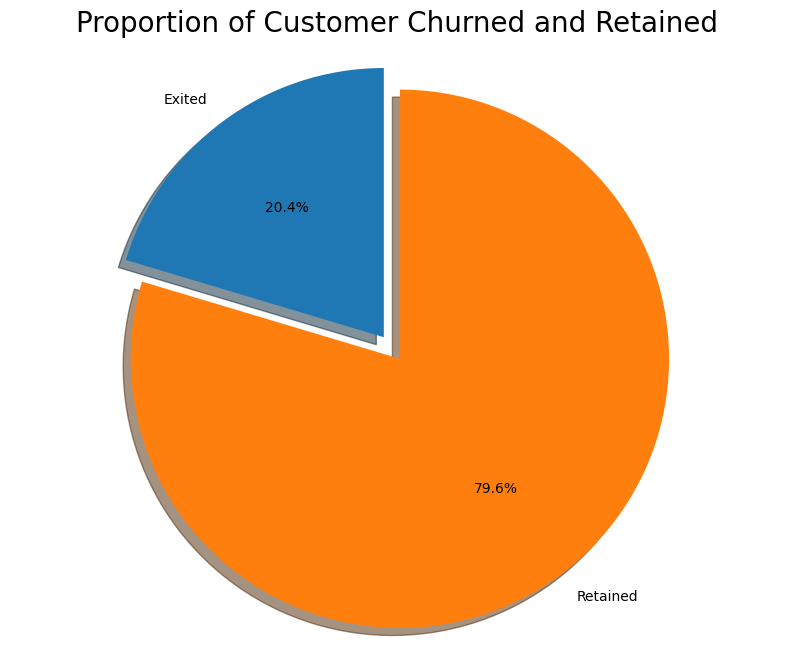

In [28]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of Customer Churned and Retained", size = 20)
plt.show()

<Axes: xlabel='IsActiveMember', ylabel='count'>

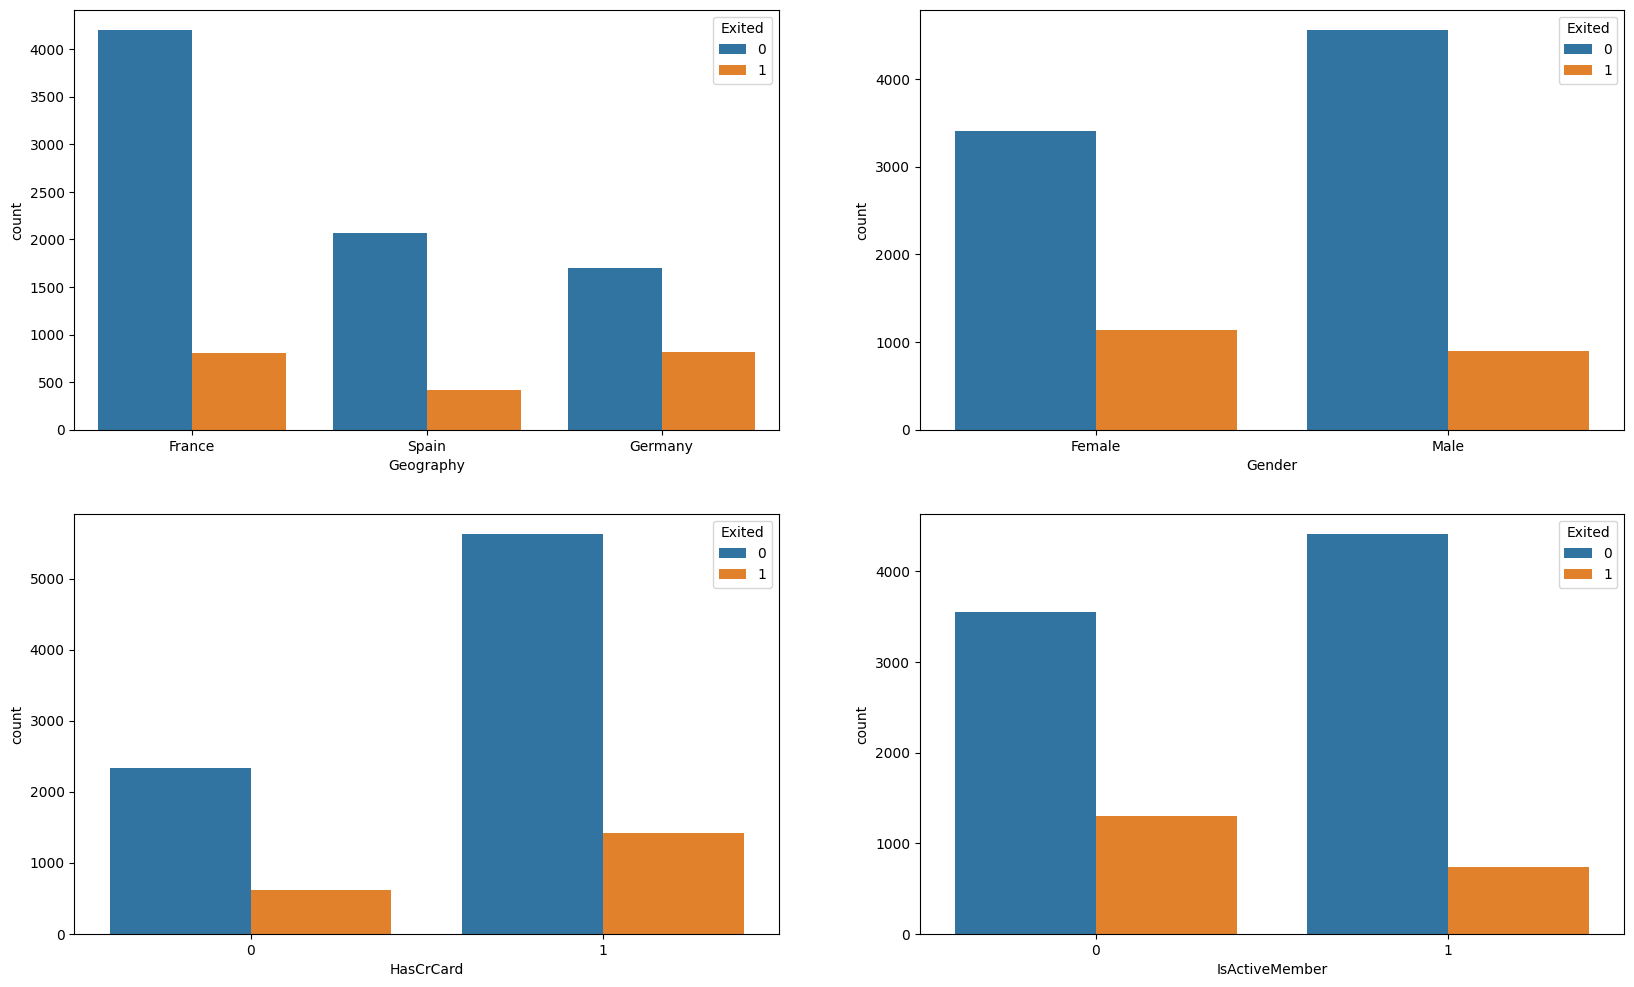

In [29]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

<Axes: xlabel='Age', ylabel='Count'>

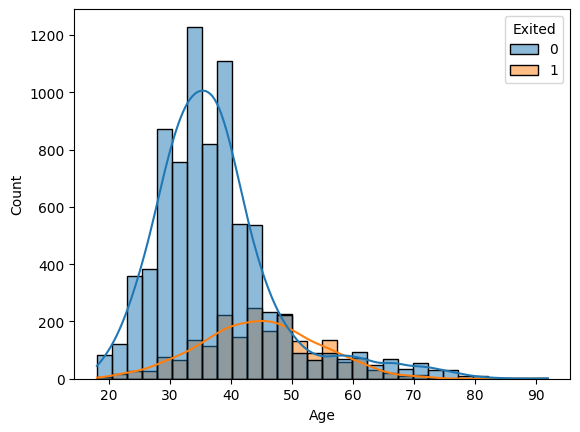

In [31]:
sns.histplot(data=df, x='Age', hue='Exited', bins=30, kde=True)


In [36]:
print(df.groupby('Geography')['Exited'].mean())
print(df.groupby('Gender')['Exited'].mean())
print(df.groupby('HasCrCard')['Exited'].mean())
print(df.groupby('IsActiveMember')['Exited'].mean())
print(df.groupby('Age')['Exited'].mean())

Geography
France     0.161548
Germany    0.324432
Spain      0.166734
Name: Exited, dtype: float64
Gender
Female    0.250715
Male      0.164559
Name: Exited, dtype: float64
HasCrCard
0    0.208149
1    0.201843
Name: Exited, dtype: float64
IsActiveMember
0    0.268509
1    0.142691
Name: Exited, dtype: float64
Age
18    0.090909
19    0.037037
20    0.050000
21    0.056604
22    0.142857
        ...   
83    0.000000
84    0.500000
85    0.000000
88    0.000000
92    0.000000
Name: Exited, Length: 70, dtype: float64


# Data Cleaning & Preprocessing

In [13]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [14]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # Male:1, Female:0
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

print(df.head())

   CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619       0   42       2       0.00              1          1   
1          608       0   41       1   83807.86              1          0   
2          502       0   42       8  159660.80              3          1   
3          699       0   39       1       0.00              2          0   
4          850       0   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  Geography_Spain  
0               1        101348.88       1              False            False  
1               1        112542.58       0              False             True  
2               0        113931.57       1              False            False  
3               0         93826.63       0              False            False  
4               1         79084.10       0              False             True  


In [15]:
X = df.drop('Exited', axis=1)
y = df['Exited']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train 3 Classification Models

In [17]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [18]:
# Support Vector Machine (SVM)
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [19]:
#Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Optional: Hyperparameter Tuning with GridSearchCV

In [20]:
param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='roc_auc')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# Model Evaluation

--- Logistic Regression ---
Confusion Matrix:
 [[2318   98]
 [ 468  116]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      2416
           1       0.54      0.20      0.29       584

    accuracy                           0.81      3000
   macro avg       0.69      0.58      0.59      3000
weighted avg       0.78      0.81      0.77      3000

ROC AUC Score: 0.773383635353352


--- SVM ---
Confusion Matrix:
 [[2359   57]
 [ 360  224]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      2416
           1       0.80      0.38      0.52       584

    accuracy                           0.86      3000
   macro avg       0.83      0.68      0.72      3000
weighted avg       0.85      0.86      0.84      3000

ROC AUC Score: 0.8248215379207112


--- Random Forest ---
Confusion Matrix:
 [[2334   82]
 [ 315  269]]
Classification Report:
    

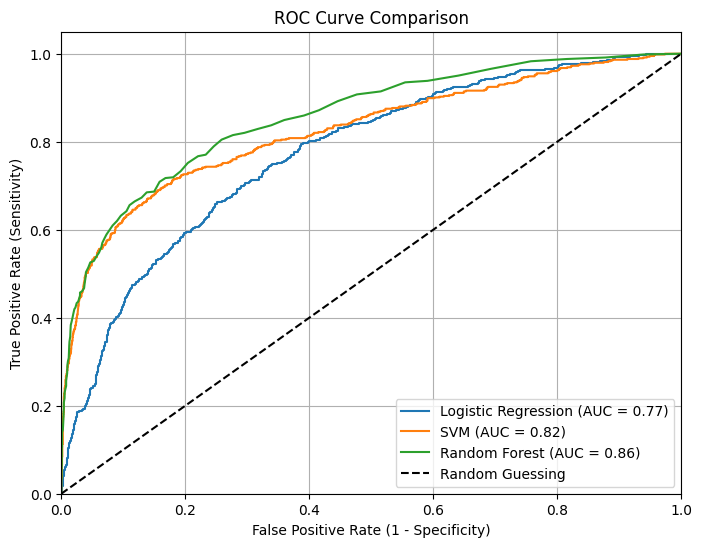

In [21]:
models = {
    "Logistic Regression": (lr, y_pred_lr),
    "SVM": (svm, y_pred_svm),
    "Random Forest": (rf, y_pred_rf)
}

for name, (model, y_pred) in models.items():
    print(f"--- {name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    print("\n")

# Predict probabilities
y_probs_lr = lr.predict_proba(X_test)[:, 1]
y_probs_svm = svm.predict_proba(X_test)[:, 1]
y_probs_rf = rf.predict_proba(X_test)[:, 1]

# Calculate ROC values
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_probs_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

# Baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Labels and Legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


The performance assessment of the models reveals that Random Forest is the most effective for predicting customer churn, achieving the highest accuracy (87%) and ROC AUC (0.86), with a recall of 48%, effectively capturing nearly half of churners. In contrast, Logistic Regression has an accuracy of 81% and a recall of only 20%, resulting in 468 missed churners, which poses a significant risk of revenue loss due to high false negatives. The Support Vector Machine (SVM) performs better than Logistic Regression with an accuracy of 86% and a recall of 38%, but still misses 62% of churners. While SVM has lower false positives than Random Forest, the latter's ability to catch more at-risk customers outweighs the cost of 81 false positives. Therefore, from a business impact perspective, prioritizing the detection of churners is crucial, making Random Forest the optimal choice for effective customer retention strategies.